In [1]:
import torch
from torch import nn
import numpy as np
import normflows as nf

In [2]:
class SimpleDense(nn.Module):
    def __init__(self, input_dim) -> None:
        super().__init__()
        net = [nn.Linear(input_dim, int(2*input_dim))]
        net.append(nn.LeakyReLU(negative_slope=0.01))
        net.append(nn.Linear(int(2*input_dim), input_dim))
        self.nets = nn.Sequential(*net)

    def forward(self, x):
        return self.nets(x)

In [3]:
x = torch.tensor(np.array([[1.0, 2.0], [1.0, 2.5], [8.0, 9.0]]))
aimple_model = SimpleDense(2)

In [4]:
#forward
# y1 = x1
# y2 = x2 + a*x1

# inverse
# x1 = y1
# x2 = y2 - a*y1

def Split(z):
    pass

def Con(z1, z2):
    pass

class MyNormFlow(nn.Module):
    def __init__(self, q0, dim_a) -> None:
        super().__init__()
        self.q0 = q0
        self.a = nn.Parameter(torch.ones((dim_a, 1)))
    
    def forward(self, z):
        x1, x2 = Split(z)
        y1 = x1
        y2 = x2 + self.a * x1
        #jeszcze det
        return Con(y1, y2)
    
    def inverse(self, z):
        y1, y2 = Split(z)
        x1 = y1
        x2 = y2 - self.a * y1
        #jeszcze det
        return Con(x1, x2)

## Create distribution 
$$X = \delta Z + (1 - \delta)K$$

Where:
- $Z$ is standard normal distribution $N(0,1)$
- $K$ is uniform on rectangles 
- $\delta$ is bernoulli distribution $P(\delta = 1) = 1 - P(\delta = 0)$

In [5]:

def generate_x(R_start, prob_delta = 0.5, K_intervals = torch.Tensor([[1, 1],[2,2]])):

    # Sample from X
    # 1) Sample delta
    delta = torch.bernoulli(torch.ones((R_start, 1))*prob_delta)

    # 2) Sample from Z
    m = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
    Z = m.sample((R_start,))

    # 3) Sample from K
    K = torch.rand(R_start, 2)


    #1st row
    K_start = K_intervals[0][None, :] # dimension expanded

    # start minus end
    K_range = torch.diff(K_intervals, dim = 0)

    #K times range plus starting points
    K = K *  K_range + K_start

    # 4) Take X
    return delta * Z   + (1 - delta) * K



In [6]:
R_start = 1000
prob_delta = 0.8

#1st row - starts
#2nd row - ends

K_intervals = torch.Tensor([[0.5, 1],
                        [3,3]])

generate_x(R_start=R_start, prob_delta=prob_delta, K_intervals=K_intervals)

tensor([[ 1.1512,  0.2716],
        [ 2.7945,  2.4167],
        [ 0.7170,  2.5062],
        ...,
        [-0.2691, -0.1645],
        [-1.2698,  1.2669],
        [ 0.4089, -0.5381]])

In [7]:
X = generate_x(1000)
sample_point = X[0]


def calculate_pdf(sample_point, prob_delta = 0.5):
    m = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
    K_area = torch.prod(torch.diff(K_intervals, dim = 0))

    if len(sample_point.shape) == 1:
        is_in_area = torch.sum(
            torch.logical_and(
                torch.gt(sample_point, K_intervals[0]),
                torch.lt(sample_point, K_intervals[1])
                )
            )
        return prob_delta * np.exp(m.log_prob(sample_point)) + (1 - prob_delta) * (1 / K_area) * is_in_area
    elif len(sample_point.shape) == 2:
        is_in_area = \
        torch.eq( 
        torch.sum(torch.logical_and(
            torch.gt(sample_point, K_intervals[0]),
            torch.lt(sample_point, K_intervals[1])), dim = 1), 
        sample_point.shape[1] * torch.ones((sample_point.shape[0],)))

        return prob_delta * np.exp(m.log_prob(sample_point)) + (1 - prob_delta) * (1 / K_area) * is_in_area

c:\Users\Sacia\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
<ipython-input-8-099aacdca21b>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c =  plt.pcolormesh(xx, yy, prob)


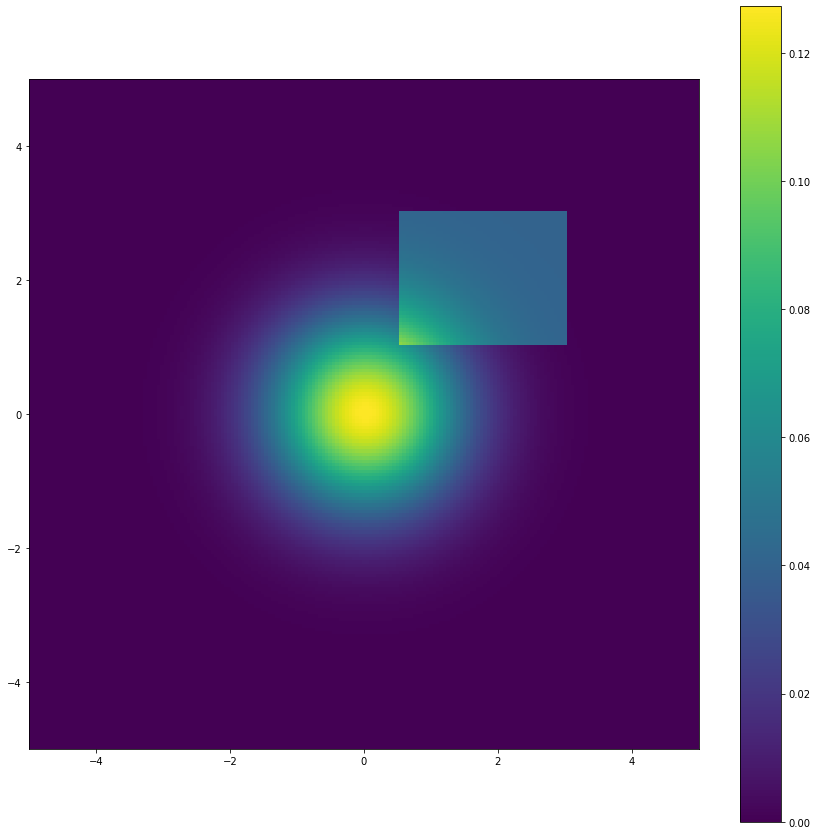

In [8]:
# Plot distribution
import matplotlib.pyplot as plt

middle_point = [0,0]
range_p = [5, 5]

grid_size = 200
xx, yy = torch.meshgrid(torch.linspace((middle_point[0]-range_p[0]), (middle_point[0]+range_p[0]), grid_size), torch.linspace((middle_point[1]-range_p[1]), (middle_point[1]+range_p[1]), grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)

prob = calculate_pdf(zz, prob_delta = prob_delta)[:, None].reshape(200, 200)

plt.figure(figsize=(15, 15))
c =  plt.pcolormesh(xx, yy, prob)
plt.colorbar(c)
plt.gca().set_aspect('equal', 'box')
plt.show()

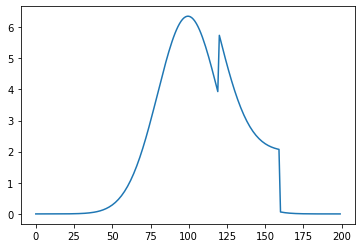

In [9]:
plt.plot(np.sum(prob.numpy(), axis =0))

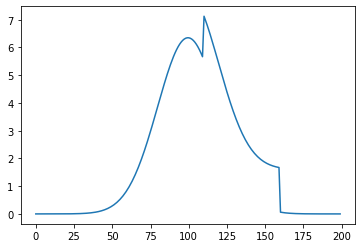

In [10]:
plt.plot(np.sum(prob.numpy(), axis = 1))

In [11]:
class MyDistribution(nn.Module):

    def __init__(self):
        super().__init__()
    
    def forward(self, num_samples):
        """Sample from distribution and calculate log prob"""
        raise NotImplementedError
    
    def log_prob(self, z):
        """Calculate log prob for batch"""
        raise NotImplementedError


class NormUnif(MyDistribution):
    def __init__(self, x_dim, prob_delta, K_intervals):
        super().__init__()

        self.x_dim = x_dim
        self.prob_delta = prob_delta
        self.K_intervals = K_intervals

        self.m = torch.distributions.MultivariateNormal(torch.zeros(self.x_dim), torch.eye(self.x_dim))

    def calculate_pdf(self, sample_point):
        K_area = torch.prod(torch.diff(self.K_intervals, dim = 0))

        if len(sample_point.shape) == 1:
            is_in_area = torch.sum(
                torch.logical_and(
                    torch.gt(sample_point, self.K_intervals[0]),
                    torch.lt(sample_point, self.K_intervals[1])
                    )
                )
            return self.prob_delta * np.exp(m.log_prob(sample_point)) + (1 - self.prob_delta) * (1 / K_area) * is_in_area

        elif len(sample_point.shape) == 2:
            is_in_area = \
            torch.eq( 
            torch.sum(torch.logical_and(
                torch.gt(sample_point, self.K_intervals[0]),
                torch.lt(sample_point, self.K_intervals[1])), dim = 1), 
            sample_point.shape[1] * torch.ones((sample_point.shape[0],)))

            return self.prob_delta * np.exp(self.m.log_prob(sample_point)) + (1 - self.prob_delta) * (1 / K_area) * is_in_area

    def log_prob(self, z):
        return torch.log(self.calculate_pdf(z))


    def forward(self, num_samples=1):
        # Sample from X
        # 1) Sample delta
        delta = torch.bernoulli(torch.ones((num_samples, 1))*self.prob_delta)

        # 2) Sample from Z
        
        Z = self.m.sample((num_samples,))

        # 3) Sample from K
        K = torch.rand(num_samples, self.x_dim)


        #1st row
        K_start = K_intervals[0][None, :] # dimension expanded

        # start minus end
        K_range = torch.diff(K_intervals, dim = 0)

        #K times range plus starting points
        K = K *  K_range + K_start

        # 4) Take X

        X = delta * Z   + (1 - delta) * K
        return  X, self.log_prob(X)


In [12]:
K_intervals = torch.Tensor([[0.5, 1],
                        [3,3]])

nu = NormUnif(x_dim = 2, prob_delta=0.5, K_intervals=K_intervals)

In [13]:
nu.forward(10)

(tensor([[ 2.4829,  1.3624],
         [ 2.0769,  2.9579],
         [ 2.0920,  1.0759],
         [ 1.0986,  2.9322],
         [ 1.9952,  2.5548],
         [-1.6316,  0.1897],
         [-0.2094,  0.3579],
         [-1.0217, -1.6448],
         [ 0.9662,  0.3659],
         [ 1.3399,  2.7638]]),
 tensor([-2.2883, -2.3014, -2.2538, -2.2967, -2.2984, -3.8801, -2.6170, -4.4057,
         -3.0647, -2.2955]))

In [14]:
dg = nf.distributions.DiagGaussian(2)
dg.forward(10)

(tensor([[ 0.2175,  0.9252],
         [ 0.2175, -1.0795],
         [-1.1782, -1.7077],
         [ 0.1970,  1.6814],
         [ 1.0349, -0.1551],
         [-0.4181,  0.0611],
         [-2.0807,  0.0593],
         [ 2.0523, -0.5215],
         [ 1.4398, -1.4849],
         [-1.7423,  0.9610]], grad_fn=<AddBackward0>),
 tensor([-2.2895, -2.4442, -3.9900, -3.2709, -2.3854, -1.9272, -4.0042, -4.0798,
         -3.9768, -3.8174], grad_fn=<RsubBackward1>))

## Create a model - with one affine coupling block

In [22]:
#2D data

def Split(z):
    return z[:,0][:, None], z[:,1][:, None]
def Con(y1, y2):
    return torch.cat((y1, y2), 1)

def zero_log_det_like_z(z):
    return torch.zeros(z.shape[0], dtype=z.dtype, device=z.device)

class AffineSingleBlock(nn.Module):
    def __init__(self):
        super().__init__()

        self.a = torch.tensor([[1]])
    
    def forward(self, z):
        x1, x2 = Split(z)
        y1 = x1
        y2 = x2 + self.a * x1
        log_det = zero_log_det_like_z(y1)
        return Con(y1, y2), log_det

    def inverse(self, z):
        y1, y2 = Split(z)
        x1 = y1
        x2 = y2 - self.a * y1
        log_det = zero_log_det_like_z(y1)
        return Con(x1, x2), log_det


class AffineMultipleBlocks(nn.Module):
    def __init__(self, num_affine_blocks=3):
        super().__init__()

        self.flows = nn.ModuleList([])
        for i in range(num_affine_blocks):
            self.flows += [AffineSingleBlock()]

    def forward(self, z):
        log_det_total = zero_log_det_like_z(z)
        for flow in self.flows:
            z, log_det = flow(z)
            log_det_total += log_det
        return z, log_det_total[:, None]
    
    def inverse(self, z):
        log_det_total = zero_log_det_like_z(z)
        for i in range(len(self.flows) - 1, -1, -1):
            z, log_det = self.flows[i].inverse(z)
            log_det_total += log_det
        return z, log_det_total[:, None]

In [23]:
amb = AffineMultipleBlocks(num_affine_blocks=1)
amb(X)

(tensor([[-0.7967, -0.2974],
         [-0.6872,  1.5592],
         [ 0.5210, -0.4374],
         ...,
         [ 1.9037,  3.6279],
         [ 1.5827, -0.2273],
         [ 0.4527,  1.3879]]),
 tensor([[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
